In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input,Conv2D,Conv2DTranspose,Dense,Flatten,ReLU,Reshape
from keras.models import Model
from keras.backend import int_shape
from keras.datasets import cifar10
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
import os

In [2]:
(x_train,_),(x_test,_) = cifar10.load_data()

In [3]:
img_save_dir = os.path.join(os.getcwd(),'saved_imgs')
if not os.path.isdir(img_save_dir):
    os.makedirs(img_save_dir)

In [4]:
def grayout(rgb):
    return np.dot(rgb[...,:3],[0.299,0.587,0.114])

In [5]:
x_train.shape

(50000, 32, 32, 3)

In [6]:
x_train_gray = grayout(x_train)
x_test_gray = grayout(x_test)

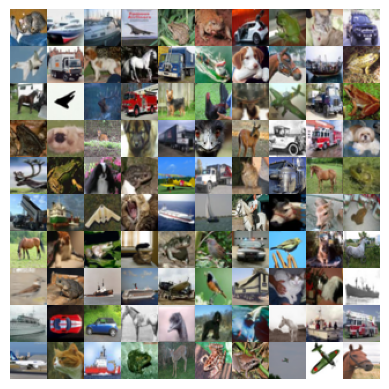

In [7]:
imgs = x_test[:100]
imgs = imgs.reshape((10,10,32,32,3))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.axis('off')
plt.imshow(imgs)
plt.show()

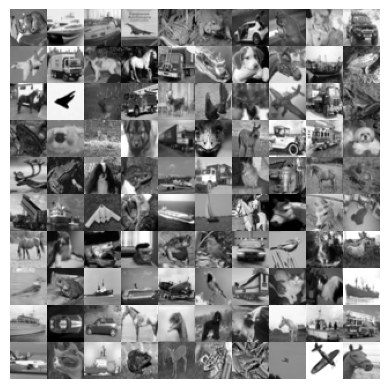

In [8]:
imgs = x_test_gray[:100]
imgs = imgs.reshape((10,10,32,32,1))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.axis('off')
plt.imshow(imgs,cmap='gray')
plt.show()

In [9]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

x_train_gray = x_train_gray.astype('float32')/255
x_test_gray = x_test_gray.astype('float32')/255

In [10]:
x_train[0]

array([[[0.23137255, 0.24313726, 0.24705882],
        [0.16862746, 0.18039216, 0.1764706 ],
        [0.19607843, 0.1882353 , 0.16862746],
        ...,
        [0.61960787, 0.5176471 , 0.42352942],
        [0.59607846, 0.49019608, 0.4       ],
        [0.5803922 , 0.4862745 , 0.40392157]],

       [[0.0627451 , 0.07843138, 0.07843138],
        [0.        , 0.        , 0.        ],
        [0.07058824, 0.03137255, 0.        ],
        ...,
        [0.48235294, 0.34509805, 0.21568628],
        [0.46666667, 0.3254902 , 0.19607843],
        [0.47843137, 0.34117648, 0.22352941]],

       [[0.09803922, 0.09411765, 0.08235294],
        [0.0627451 , 0.02745098, 0.        ],
        [0.19215687, 0.10588235, 0.03137255],
        ...,
        [0.4627451 , 0.32941177, 0.19607843],
        [0.47058824, 0.32941177, 0.19607843],
        [0.42745098, 0.28627452, 0.16470589]],

       ...,

       [[0.8156863 , 0.6666667 , 0.3764706 ],
        [0.7882353 , 0.6       , 0.13333334],
        [0.7764706 , 0

In [11]:
x_train = x_train.reshape(x_train.shape[0],32,32,3)
x_test = x_test.reshape(x_test.shape[0],32,32,3)

x_train_gray = x_train_gray.reshape(x_train_gray.shape[0],32,32,1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0],32,32,1)

In [12]:
# Network parameters
input_shape = (32,32,1)
batch_size = 32
kernel_size = 3
latent_dim = 256

layers = [64,128,256]

In [13]:
# Encoder Network
input_layer = Input(shape=input_shape,name='encoder_in')

x = input_layer

for li in layers:
    conv_layer = Conv2D(filters=li,
                        kernel_size=kernel_size,
                        strides=2,
                        padding='same')
    x = conv_layer(x)
    x = ReLU()(x)

shape = int_shape(x)

x = Flatten()(x)

z_dim = Dense(latent_dim,name = 'latent_vec')(x)

encoder = Model(input_layer,z_dim,name='encoder')

In [14]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_in (InputLayer)     [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        640       
                                                                 
 re_lu (ReLU)                (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 re_lu_1 (ReLU)              (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         295168    
                                                                 
 re_lu_2 (ReLU)              (None, 4, 4, 256)         0   

In [15]:
# Decoder Model
decoder_input = Input(shape=(latent_dim,),name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(decoder_input)
x = Reshape((shape[1],shape[2],shape[3]))(x)


In [16]:
for units in layers[::-1]:
    conv_t_layer = Conv2DTranspose(filters=units, kernel_size=kernel_size,strides=2,padding='same')
    x = conv_t_layer(x)
    x = ReLU()(x)

output_layer = Conv2DTranspose(filters=3,
                               kernel_size=kernel_size,
                               padding='same',
                               activation='sigmoid',
                               name='decoder_output')(x)

In [17]:
decoder = Model(decoder_input,output_layer,name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 256)]             0         
                                                                 
 dense (Dense)               (None, 4096)              1052672   
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        590080    
 nspose)                                                         
                                                                 
 re_lu_3 (ReLU)              (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      295040    
 ranspose)                                                 

In [18]:
autoencoder = Model(input_layer,decoder(encoder(input_layer)),name='colorizer')
autoencoder.summary()

Model: "colorizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_in (InputLayer)     [(None, 32, 32, 1)]       0         
                                                                 
 encoder (Functional)        (None, 256)               1418496   
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         2013315   
                                                                 
Total params: 3,431,811
Trainable params: 3,431,811
Non-trainable params: 0
_________________________________________________________________


In [19]:
opt = Adam(learning_rate=0.001)
autoencoder.compile(loss='mse',optimizer=opt)

In [20]:
saved_model_dir = os.path.join(os.getcwd(),'saved_models')
if not os.path.isdir(saved_model_dir):
    os.makedirs(saved_model_dir)

In [24]:
path = os.path.join(saved_model_dir,'colorizer_model.h5')

In [25]:
# Model Checkpoint
checkpoint = ModelCheckpoint(filepath=path, monitor='val_loss', verbose=1,save_best_only=True)

In [26]:
callbacks = [checkpoint]
autoencoder.fit(x_train_gray,x_train,
                validation_data=(x_test_gray,x_test),
                epochs=25,
                batch_size=32,
                callbacks = callbacks)

Epoch 1/25
1562/1563 [============================>.] - ETA: 0s - loss: 0.0102
Epoch 1: val_loss improved from inf to 0.00975, saving model to g:\Generative-deep-learning\Autoencoders\saved_models\colorizer_model.h5
1563/1563 [==============================] - 41s 26ms/step - loss: 0.0102 - val_loss: 0.0098
Epoch 2/25
1563/1563 [==============================] - ETA: 0s - loss: 0.0092
Epoch 2: val_loss improved from 0.00975 to 0.00905, saving model to g:\Generative-deep-learning\Autoencoders\saved_models\colorizer_model.h5
1563/1563 [==============================] - 43s 28ms/step - loss: 0.0092 - val_loss: 0.0091
Epoch 3/25
1561/1563 [============================>.] - ETA: 0s - loss: 0.0085
Epoch 3: val_loss improved from 0.00905 to 0.00828, saving model to g:\Generative-deep-learning\Autoencoders\saved_models\colorizer_model.h5
1563/1563 [==============================] - 45s 29ms/step - loss: 0.0085 - val_loss: 0.0083
Epoch 4/25
1563/1563 [==============================] - ETA: 0s -

In [27]:
x_hat = autoencoder.predict(x_test_gray)

313/313 [==============================] - 4s 11ms/step


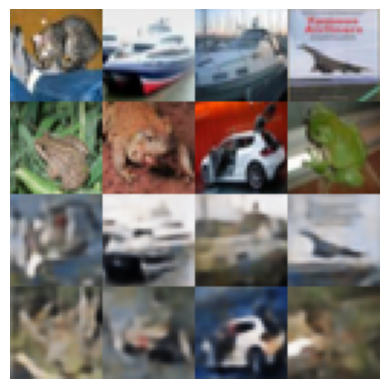

In [34]:
images = np.concatenate([x_test[:8],x_hat[:8]])
images = images.reshape([4,4,32,32,3])
plt.axis('off')
plt.imshow(np.vstack([np.hstack(i) for i in images]))